In [115]:
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [116]:
from nltk.corpus import brown
import pandas as pd
import xlsxwriter
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [117]:
#preprocessing
fo = pd.ExcelFile('clean-data.xlsx')
df = pd.read_excel(fo, 'Sheet1')

#STOPWORDS = stopwords.words('english')
stopwords = stopwords.words('english')
punctuation = set(string.punctuation) 
lemmatize = WordNetLemmatizer() 
#def clean_text(text):
#    tokenized_text = word_tokenize(text.lower())
#    cleaned_text = [t for t in tokenized_text if t not in STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
#    return cleaned_text

def cleaning(article):
    one = " ".join([i for i in article.lower().split() if i not in stopwords])
    two = "".join(i for i in one if i not in punctuation)
    three = " ".join(lemmatize.lemmatize(i) for i in two.split())
    return three

#remove sentence which contains only one word
def removeSentence(str): 
    word = str.split()
    wordCount = len(word)
    if(wordCount<=1):
        str = ''
    
    return str

def preprocessing(str):
    str = removeSentence(str)
    str = cleaning(str)
    #return ' '.join(str)
    return str

In [118]:
#test the code
sentences = ["councillor to contest wollongong as independent","s"]

for st in sentences:
    r = preprocessing(st)
    print(r)

councillor contest wollongong independent



In [119]:
fo = pd.read_excel('headline_news.xlsx', sheet_name='Sheet1') #read excel file
txt = fo['headline_text']
workbook = xlsxwriter.Workbook('clean-data-headline.xlsx')
worksheet = workbook.add_worksheet()

row = 0
col = 0

rowHeaders = ['headline_text']
worksheet.write_row(row, col,  tuple(rowHeaders))
        
for t in txt:
    new_txt = preprocessing(t)
    rowValues = [new_txt]
    row += 1
    worksheet.write_row(row, col, tuple(rowValues))
    
workbook.close()

In [120]:
fo = pd.ExcelFile('clean-data-headline.xlsx')
df = pd.read_excel(fo, 'Sheet1')

text = df['headline_text']
text_list =  [i.split() for i in text]
print(len(text_list))

1998


In [121]:
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(text_list, min_count=10)
trigram = Phrases(bigram[text_list], min_count=10)

for idx in range(len(text_list)):
    for token in bigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)
    for token in trigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)

C:\Users\ACER\Anaconda3\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [141]:
from gensim import corpora, models
# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(text_list)
dictionary.filter_extremes(no_below=5, no_above=0.2)
print(dictionary)

Dictionary(519 unique tokens: ['community', 'act', 'fire', 'must', 'call']...)


In [142]:
#build corpus
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]

print(len(doc_term_matrix))
print(doc_term_matrix[100])

tfidf = models.TfidfModel(doc_term_matrix)
corpus_tfidf = tfidf[doc_term_matrix]

1998
[(51, 1), (183, 1)]


In [143]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
#function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

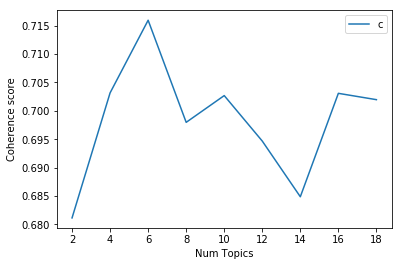

In [144]:
start=2
limit=20
step=2
model_list, coherence_values = compute_coherence_values(dictionary, corpus=corpus_tfidf, 
                                                        texts=text_list, start=start, limit=limit, step=step)
#show graphs
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [145]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6811
Num Topics = 4  has Coherence Value of 0.7032
Num Topics = 6  has Coherence Value of 0.716
Num Topics = 8  has Coherence Value of 0.698
Num Topics = 10  has Coherence Value of 0.7027
Num Topics = 12  has Coherence Value of 0.6947
Num Topics = 14  has Coherence Value of 0.6849
Num Topics = 16  has Coherence Value of 0.7031
Num Topics = 18  has Coherence Value of 0.702


In [146]:
from pprint import pprint
# Build the LDA model
lda_model = models.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)
print("LDA model :")
pprint(lda_model.print_topics())

LDA model :
[(0,
  '0.013*"call" + 0.013*"win" + 0.012*"police" + 0.010*"u" + 0.010*"fund" + '
  '0.009*"price" + 0.009*"end" + 0.009*"river" + 0.009*"crash" + 0.008*"war"'),
 (1,
  '0.016*"face_court" + 0.014*"man" + 0.013*"warne" + 0.013*"n_korea" + '
  '0.013*"council" + 0.012*"murder" + 0.012*"police" + 0.009*"aid" + '
  '0.009*"court" + 0.009*"death"'),
 (2,
  '0.016*"rain" + 0.014*"u" + 0.012*"iraq" + 0.011*"new" + 0.010*"missile" + '
  '0.009*"top" + 0.009*"say" + 0.009*"man" + 0.008*"defence" + 0.008*"fight"'),
 (3,
  '0.016*"plan" + 0.013*"back" + 0.012*"council" + 0.012*"may" + 0.012*"water" '
  '+ 0.010*"u" + 0.010*"offer" + 0.009*"work" + 0.009*"zimbabwe" + '
  '0.009*"govt"'),
 (4,
  '0.010*"world" + 0.010*"ban" + 0.009*"concern" + 0.009*"police" + '
  '0.009*"fire" + 0.009*"claim" + 0.008*"court" + 0.008*"dy" + 0.008*"man" + '
  '0.008*"back"')]


In [147]:
lda_model.save('topic.model')

In [148]:
from gensim.models import LdaModel
loading = LdaModel.load('topic.model')

In [149]:
print(loading.print_topics(num_topics=2, num_words=4))

[(1, '0.016*"face_court" + 0.014*"man" + 0.013*"warne" + 0.013*"n_korea"'), (3, '0.016*"plan" + 0.013*"back" + 0.012*"council" + 0.012*"may"')]


In [150]:
def pre_new(text):
    one = cleaning(text).split()
    two = dictionary.doc2bow(one)
    return two

In [151]:
pre_new('new article that to be classified by trained model!')

[(193, 1)]

In [152]:
belong = loading[(pre_new('new article that to be classified by trained model!'))]
belong

[(0, 0.102269836),
 (1, 0.10104911),
 (2, 0.5930733),
 (3, 0.10132436),
 (4, 0.10228339)]

In [153]:
new = pd.DataFrame(belong,columns=['publish_date','prob']).sort_values('prob',ascending=False)
new['headline_text'] = new['publish_date'].apply(loading.print_topic)
new

,publish_date,prob,headline_text
2,2,0.593073,"0.016*""rain"" + 0.014*""u"" + 0.012*""iraq"" + 0.01..."
4,4,0.102283,"0.010*""world"" + 0.010*""ban"" + 0.009*""concern"" ..."
0,0,0.102270,"0.013*""call"" + 0.013*""win"" + 0.012*""police"" + ..."
3,3,0.101324,"0.016*""plan"" + 0.013*""back"" + 0.012*""council"" ..."
1,1,0.101049,"0.016*""face_court"" + 0.014*""man"" + 0.013*""warn..."


In [154]:
new['headline_text']

2    0.016*"rain" + 0.014*"u" + 0.012*"iraq" + 0.01...
4    0.010*"world" + 0.010*"ban" + 0.009*"concern" ...
0    0.013*"call" + 0.013*"win" + 0.012*"police" + ...
3    0.016*"plan" + 0.013*"back" + 0.012*"council" ...
1    0.016*"face_court" + 0.014*"man" + 0.013*"warn...
Name: headline_text, dtype: object

In [155]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

In [162]:
pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary)

C:\Users\ACER\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.010473  0.010011       1        1  21.362881
2      0.007720 -0.116151       2        1  20.721838
1      0.105635  0.027537       3        1  20.540340
3     -0.104125  0.019029       4        1  19.505075
4      0.001244  0.059575       5        1  17.869860, topic_info=     Category       Freq         Term      Total  loglift  logprob
term                                                              
211   Default  11.000000   face_court  11.000000  30.0000  30.0000
469   Default   9.000000      n_korea   9.000000  29.0000  29.0000
22    Default  21.000000      council  21.000000  28.0000  28.0000
15    Default  14.000000          win  14.000000  27.0000  27.0000
150   Default  11.000000       murder  11.000000  26.0000  26.0000
281   Default  12.000000        warne  12.000000  25.0000  25.0000
484   Default   8.000000      missile   8.000000  24.0000  24.0000
30    Default   6.000000          aid   6.000000  23.0000  23.0000
113   Default  15.000000         back  15.000000  22.0000  22.0000
61    Default   9.000000         fund   9.000000  21.0000  21.0000
194   Default   7.000000     zimbabwe   7.000000  20.0000  20.0000
35    Default  19.000000         plan  19.000000  19.0000  19.0000
123   Default  10.000000        offer  10.000000  18.0000  18.0000
184   Default   8.000000      concern   8.000000  17.0000  17.0000
161   Default  10.000000          qld  10.000000  16.0000  16.0000
446   Default   7.000000           dy   7.000000  15.0000  15.0000
244   Default   6.000000        stock   6.000000  14.0000  14.0000
73    Default   6.000000     decision   6.000000  13.0000  13.0000
64    Default   6.000000          cut   6.000000  12.0000  12.0000
260   Default   5.000000       future   5.000000  11.0000  11.0000
202   Default  13.000000          say  13.000000  10.0000  10.0000
324   Default   6.000000  investigate   6.000000   9.0000   9.0000
4     Default  14.000000         call  14.000000   8.0000   8.0000
457   Default   7.000000       return   7.000000   7.0000   7.0000
343   Default  11.000000        price  11.000000   6.0000   6.0000
366   Default   9.000000          top   9.000000   5.0000   5.0000
41    Default  16.000000        water  16.000000   4.0000   4.0000
109   Default  11.000000         work  11.000000   3.0000   3.0000
359   Default   8.000000          one   8.000000   2.0000   2.0000
111   Default  14.000000        court  14.000000   1.0000   1.0000
...       ...        ...          ...        ...      ...      ...
389    Topic5   2.027218       nation   3.669467   1.1287  -5.6253
121    Topic5   1.996781      smoking   3.663912   1.1151  -5.6404
118    Topic5   5.786476          ban  10.954807   1.0838  -4.5764
137    Topic5   1.748187      storage   3.341369   1.0743  -5.7733
53     Topic5   2.755639       attack   5.270390   1.0736  -5.3183
178    Topic5   1.841944         hill   3.528690   1.0719  -5.7211
189    Topic5   2.015838        clear   3.870208   1.0698  -5.6309
289    Topic5   1.628893       higher   3.144295   1.0644  -5.8440
511    Topic5   2.043140        blast   3.944161   1.0643  -5.6174
126    Topic5   3.267088        group   6.326091   1.0613  -5.1480
290    Topic5   3.657466         land   7.474176   1.0074  -5.0352
6      Topic5   3.530237          air   7.378634   0.9848  -5.0706
208    Topic5   5.883877        world  14.033459   0.8528  -4.5597
77     Topic5   3.448318     expected   7.492442   0.9460  -5.0940
161    Topic5   4.432644          qld  10.216652   0.8870  -4.8429
420    Topic5   3.874032         year   9.079147   0.8704  -4.9776
185    Topic5   4.030183     hospital  10.258218   0.7878  -4.9381
352    Topic5   3.315681           pm   7.821220   0.8639  -5.1333
187    Topic5   4.890926        claim  15.532907   0.5665  -4.7445
111    Topic5   4.701732        court  14.603968   0.5887  -4.7840
2      Topic5   4.973941    

In [63]:
# Build the LSI model
lsi_model = models.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)
print("LSI model :")
pprint(lsi_model.print_topics())

LSI model :
[(0,
  '0.566*"rain" + 0.441*"man" + 0.347*"water" + 0.266*"police" + '
  '0.207*"council" + 0.147*"court" + 0.139*"murder" + 0.113*"new" + '
  '0.106*"face" + 0.105*"may"'),
 (1,
  '0.578*"man" + -0.511*"rain" + 0.297*"police" + -0.291*"water" + '
  '0.186*"court" + 0.183*"murder" + -0.153*"council" + 0.142*"face" + '
  '0.113*"charged" + 0.092*"charge"'),
 (2,
  '-0.702*"new" + -0.380*"iraq" + -0.267*"council" + 0.207*"rain" + '
  '0.196*"man" + -0.179*"govt" + -0.151*"resolution" + -0.141*"war" + '
  '0.096*"water" + -0.087*"nsw"'),
 (3,
  '-0.856*"council" + 0.373*"new" + 0.215*"rain" + -0.074*"welcomes" + '
  '-0.072*"land" + 0.062*"resolution" + -0.062*"police" + -0.061*"change" + '
  '-0.060*"rejects" + -0.058*"security"'),
 (4,
  '-0.779*"police" + 0.393*"man" + -0.164*"investigate" + -0.162*"death" + '
  '-0.153*"probe" + 0.137*"new" + 0.129*"council" + 0.121*"court" + '
  '-0.086*"cannabis" + -0.084*"fatal"')]


In [167]:
import pandas as pd
top_words_per_topic = []
for t in range(lsi_model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in model.show_topic(t, topn = 10)])

#pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words.csv")
df = pd.DataFrame(top_words_per_topic, columns=['publish_date', 'headline_text','P']).to_csv("top_wordslsi_model.csv")
print(df)

None


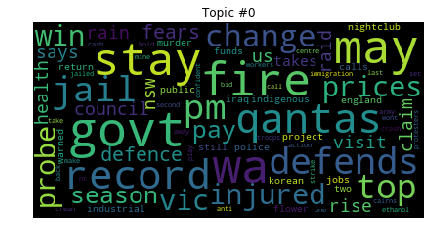

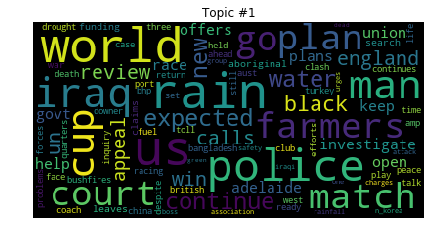

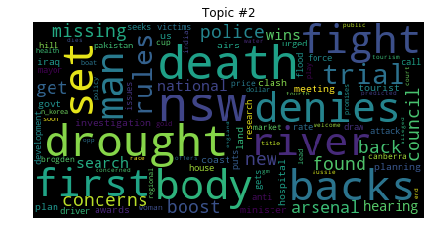

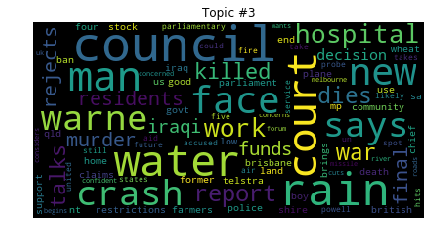

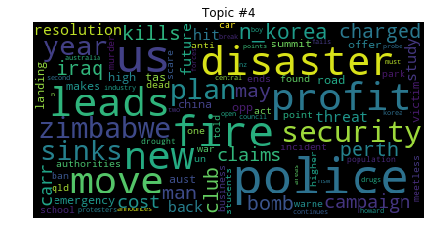

In [168]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud as wd

for t in range(lsi_model.num_topics):
    plt.figure(figsize=(7,10))
    plt.imshow(wd(max_font_size=50, min_font_size=6). fit_words(dict(model.show_topic(t,200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.savefig("wcld-topic-#"+str(t)+".png", facecolor='k',bbox_inches='tight')
    
plt.show()

In [94]:
#put the models to work and transform unseen documents to their topic distribution:
text = "property market value drop"
bow = dictionary.doc2bow(clean_text(text))

print(bow)
print(clean_text(text))
print(lsi_model[bow])

[(393, 1)]
['property', 'market', 'value', 'drop']
[(0, 0.005502652628429482), (1, -0.001300570104100264), (2, -0.02670628351189098), (3, 0.011621552582242388), (4, 0.01948067580383791)]


In [84]:
print(lda_model[bow])

[(0, 0.100008965), (1, 0.10109872), (2, 0.598875), (3, 0.1000099), (4, 0.10000741)]
